<div style="text-align: center;">
    King Fahd University of Petroleum & Minerals <br>
    College of Computing and Mathematics <br>
    Information and Computer Science Department
</div>

<div style="text-align: center;">
    241-ICS-560-1 (Foundations of Quantum Computing)
</div>

<div style="text-align: center;">
    Quantum Key Distribution: A Simple BB84 Protocol Simulation
</div>

<div style="text-align: center;">
    Omar Saeed Alshammari, 200819560 <br>
    Bander Saeed Alshammari, 201239040
</div>

<div style="text-align: center;">
    Dr Alawi A. Al-Saggaf
</div>

<div style="text-align: center;">
    13 Dec 2024
</div>


# Table of Contents
1. [Project Overview](#Project-Overview)
2. [Background and Literature Review](#Background-and-Literature-Review)
3. [Methodology](#Methodology)
4. [Implementation](#Implementation)
5. [Results and Analysis](#Results-and-Analysis)
6. [Challenges Encountered](#Challenges-Encountered)
7. [Conclusion](#Conclusion)
8. [References](#References)
9. [Demo](#Demo)

## Project Overview
The goal of this project is to simulate a Quantum Key Distribution (QKD) protocol using IBM Qiskit. QKD is a secure communication method that enables two parties to generate a shared, secret cryptographic key. The protocol leverages the principles of quantum mechanics, particularly the no-cloning theorem and measurement disturbance, to ensure security.

## Background and Literature Review
Quantum Key Distribution protocols, such as BB84, exploit quantum mechanics to secure communication channels. BB84 was introduced in 1984 by Bennett and Brassard and has become the foundation for most QKD implementations. Unlike classical encryption methods, QKD ensures that any eavesdropping attempts disturb the quantum states, which can then be detected. Recent advancements in quantum computing frameworks, such as Qiskit, have made it possible to simulate and test QKD protocols in virtual environments. This simulation aims to demonstrate the principles of QKD, focusing on the generation, transmission, and verification of a secure key.


## Methodology
The BB84 protocol was chosen as the basis for this simulation. The process involves two key participants, Alice and Bob:

1. Alice generates random quantum states based on randomly chosen bases and classical bits.

2. Alice sends the quantum states to Bob.

3. Bob randomly selects bases for measurement and measures the received states.

4. Alice and Bob sift their keys by keeping bits where their bases match.

5. A portion of the key is used to detect eavesdropping.

6. If no eavesdropping is detected, the remaining key is used as the shared secret key.

To further enhance the simulation, an eavesdropper, Eva, was introduced to intercept and measure qubits during transmission. Eva’s operations demonstrate how measurement disturbance affects the QKD process and leads to the detection of eavesdropping.

The simulation was implemented using IBM Qiskit. Quantum circuits were created to represent the preparation and measurement of qubits, and classical communication between Alice and Bob was simulated using Python functions.

## Implementation
### Alice's Operations

1. Alice creates 100 qubits initialized to |0>.
2. Random bases (Z or X) and classical bits (0 or 1) are generated.
3. Based on the random bases and bits, Alice prepares qubits using X and H gates.
4. Alice transmits the prepared qubits to Bob.

### Eva's Operations

1. Eva intercepts the qubits during transmission from Alice to Bob.
2. Eva randomly selects measurement bases (Z or X) and measures the qubits.
3. Eva re-prepares and sends the qubits to Bob after measurement.

### Bob's Operations

1. Bob generates random bases (Z or X) for measurement.
2. Bob applies the Hadamard gate to measure in the X basis where necessary.
3. Bob measures the received qubits and records the results.


### Sifting and Key Agreement
1. Alice and Bob compare their chosen bases over a classical channel.
2. Only bits with matching bases are retained to form the sifted key.
3. The presence of Eva introduces errors in the sifted key, which are detected during this phase.

At the end of the protocol, alice and bob will perfrom an hkdf operation on their sifted key to generate a shared secret that can be used to encrypt and decrypt messages. 

#### Alice Class:
```python
import random
from qiskit import QuantumCircuit
from util import Basis
from hkdf import convert
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

class Alice:
    def __init__(self, num_qubits: int, qc: QuantumCircuit):
        self.qc = qc
        self.num_qubits = num_qubits
        self.bases = [random.choice([Basis.Z, Basis.X]) for _ in range(num_qubits)]
        self.bits = [random.choice([0, 1]) for _ in range(num_qubits)]
        self.key = None
        print("Alice original bits")
        print(self.bits)

    def prepare_qubits(self):
        for i in range(self.num_qubits):
            if self.bases[i] == Basis.Z:
                # Z basis
                if self.bits[i] == 1:
                    self.qc.x(i)  # Prepare |1>
            else:
                # X basis
                self.qc.h(i)    # |0> -> |+>
                if self.bits[i] == 1:
                    self.qc.z(i) # |+> -> |->

    def sift_key(self, bob_bases):
        # Find indices where Alice’s and Bob’s bases match
        matching_indices = [i for i in range(self.num_qubits) if self.bases[i] == bob_bases[i]]
        # Extract the bits that correspond to matching bases
        sifted_bits = [self.bits[i] for i in matching_indices]
        self.key = convert(sifted_bits,48)
        print("Alice key is:")
        print(self.key)
        return sifted_bits, matching_indices
    
    def encrypt(self, plaintext: bytes) -> bytes:
        iv = self.key[:16]
        aes_key = self.key[16:]
        cipher = Cipher(algorithms.AES(aes_key), modes.CFB(iv), backend=default_backend())
        encryptor = cipher.encryptor()
        ciphertext = encryptor.update(plaintext) + encryptor.finalize()
        return ciphertext

    def decrypt(self, ciphertext: bytes) -> bytes:
        iv = self.key[:16]
        aes_key = self.key[16:]
        cipher = Cipher(algorithms.AES(aes_key), modes.CFB(iv), backend=default_backend())
        decryptor = cipher.decryptor()
        plaintext = decryptor.update(ciphertext) + decryptor.finalize()
        return plaintext
```

### Bob Class:
```python
import random
from qiskit import ClassicalRegister, QuantumCircuit
from util import Basis
from qiskit_aer import AerSimulator
from hkdf import convert
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

class Bob:
    def __init__(self, num_qubits: int, qc: QuantumCircuit):
        self.qc = qc
        self.num_qubits = num_qubits
        self.bases = [random.choice([Basis.Z, Basis.X]) for _ in range(num_qubits)]
        self.measurements = None  # Will store the measurement results
        self.key = None

    def measure_qubits(self):
        # Add a classical register if not present
        if len(self.qc.cregs) == 0:
            self.qc.add_register(ClassicalRegister(self.num_qubits))

        for i in range(self.num_qubits):
            if self.bases[i] == Basis.X:
                self.qc.h(i)  # Rotate to measure in X basis by applying H before measurement
        self.qc.barrier()

        for i in range(self.num_qubits):
            self.qc.measure(i, i)

        # Execute the circuit on a simulator
        simulator = AerSimulator()
        job = simulator.run(self.qc, shots=1)
        result = job.result()
        counts = result.get_counts()

        # counts is a dictionary like {'010101...': 1}, we extract the key
        measured_string = list(counts.keys())[0]
        # Convert measured_string into a list of ints (0/1)
        self.measurements = [int(bit) for bit in measured_string[::-1]]
        print("Bob Measurments is:")
        print(self.measurements)

    def sift_key(self, matching_indices):
        # Return the bits that correspond to the matching bases
        if self.measurements is None:
            raise ValueError("No measurements available. Please measure first.")
        sifted_bits = [self.measurements[i] for i in matching_indices]
        self.key = convert(sifted_bits,48)
        return sifted_bits

    def encrypt(self, plaintext: bytes) -> bytes:
        iv = self.key[:16]
        aes_key = self.key[16:]
        cipher = Cipher(algorithms.AES(aes_key), modes.CFB(iv), backend=default_backend())
        encryptor = cipher.encryptor()
        ciphertext = encryptor.update(plaintext) + encryptor.finalize()
        return ciphertext

    def decrypt(self, ciphertext: bytes) -> bytes:
        iv = self.key[:16]
        aes_key = self.key[16:]
        cipher = Cipher(algorithms.AES(aes_key), modes.CFB(iv), backend=default_backend())
        decryptor = cipher.decryptor()
        plaintext = decryptor.update(ciphertext) + decryptor.finalize()
        return plaintext
```

#### Eve Class
```python
import random
from qiskit import ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from util import Basis

class Eve:
    def __init__(self, num_qubits: int, qc: QuantumCircuit):
        self.qc = qc
        self.num_qubits = num_qubits
        self.bases = [random.choice([Basis.Z, Basis.X]) for _ in range(num_qubits)]
        self.measurements = None  # Will store the measurement results

    def measure_qubits(self):
        # Add a classical register if not present
        if len(self.qc.cregs) == 0:
            self.qc.add_register(ClassicalRegister(self.num_qubits))

        for i in range(self.num_qubits):
            if self.bases[i] == Basis.X:
                self.qc.h(i)  # Rotate to measure in X basis by applying H before measurement
        self.qc.barrier()
        for i in range(self.num_qubits):
            self.qc.measure(i, i)

        # Execute the circuit on a simulator
        simulator = AerSimulator()
        job = simulator.run(self.qc, shots=1)
        result = job.result()
        counts = result.get_counts()

        # counts is a dictionary like {'010101...': 1}, we extract the key
        measured_string = list(counts.keys())[0]
        # Convert measured_string into a list of ints (0/1)
        self.measurements = [int(bit) for bit in measured_string[::-1]]
```

### Util 
```python
from enum import Enum

class Basis(Enum):
    Z = 0
    X = 1
```

#### HKDF 
```python
import hashlib
import hmac
import math

# Convert bits to bytes
def bits_to_bytes(bit_array):
    byte_array = bytearray()
    for i in range(0, len(bit_array), 8):
        byte = 0
        for bit in bit_array[i:i+8]:
            byte = (byte << 1) | bit
        byte_array.append(byte)
    return bytes(byte_array)

# HKDF Extract
def hkdf_extract(salt, ikm, hash_function=hashlib.sha256):
    if salt is None:
        salt = b'\x00' * hash_function().digest_size
    return hmac.new(salt, ikm, hash_function).digest()

def hkdf_expand(prk, info, length, hash_function=hashlib.sha256):
    hash_len = hash_function().digest_size
    num_blocks = math.ceil(length / hash_len)
    okm = b''
    output_block = b''

    # Ensure `info` is bytes
    if not isinstance(info, bytes):
        info = bytes(info)  # Convert list to bytes if needed

    for i in range(1, num_blocks + 1):
        output_block = hmac.new(prk, output_block + info + bytes([i]), hash_function).digest()
        okm += output_block

    return okm[:length]

def convert(bits, output_length_in_bytes):
    if len(bits) >= output_length_in_bytes * 8:
        return bits

    ikm = bits_to_bytes(bits)   
    
    # Derive the key using HKDF
    salt = None
    prk = hkdf_extract(salt, ikm)
    okm = hkdf_expand(prk, bits, output_length_in_bytes)

    # Output the derived key as a 48-bit binary string
    output_key = int.from_bytes(okm, 'big')
    # print(f"48-bit derived key: {bin(output_key)[2:].zfill(48)}")
    return okm
```
The Qiskit AerSimulator backend was used to simulate quantum operations, and classical Python functions handled sifting and error-checking.

After defining these classes and files we implemeted two methods to simulate QKD. One without Eve in the middle, and the other with Eve in the middle.

#### Without Eve
```python
def simulate_bb84_without_eve(qc, num_qubits):
    alice = Alice(num_qubits, qc)
    bob = Bob(num_qubits, qc)

    # 1 Alice Prepare her qubits
    qc.barrier(label="Alice - Start")
    alice.prepare_qubits()
    qc.barrier(label="Alice - End")

    # 2 Bob Measure qubits
    qc.barrier(label="Bob - Start")
    bob.measure_qubits()
    qc.barrier(label="Bob - End")

    # 3 Bob shares his bases with Alice, and Alice only select the bits with matching bases.
    alice_sifted_bits, alice_matching_indices = alice.sift_key(bob.bases)
    # 4 Alice share her matching indices with Bob and bob select the qubits with matching indices.
    bob_sifted_bits = bob.sift_key(alice_matching_indices)

    print("Alice sifted bits: " + str(alice_sifted_bits))
    print("Bob sifted bits: " + str(bob_sifted_bits))

    if alice_sifted_bits == bob_sifted_bits:
        print("Key exchange was successful.")
    else:
        print("Key exchange failed.")
    
    alice_message = "Hello, Bob!".encode('utf-8')
    alice_ciphertext = alice.encrypt(alice_message)
    print(f"Alice's ciphertext: {alice_ciphertext}")
    bob_plaintext = bob.decrypt(alice_ciphertext)
    print(f"Bob's plaintext: {bob_plaintext}")

    bob_message = "Hello, Alice!".encode('utf-8')
    bob_ciphertext = bob.encrypt(bob_message)
    print(f"Bob's ciphertext: {bob_ciphertext}")
    alice_plaintext = alice.decrypt(bob_ciphertext)
    print(f"Alice's plaintext: {alice_plaintext}")
```

#### With Eve
```python
def simulate_bb84_with_eve(qc, num_qubits):
    alice = Alice(num_qubits, qc)
    bob = Bob(num_qubits, qc)
    eve = Eve(num_qubits, qc)

    # 1 Alice Prepare her qubits
    qc.barrier(label="Alice - Start")
    alice.prepare_qubits()
    qc.barrier(label="Alice - End")

    # 2 Eve tries to guess Alice bases and measure in same bases as Alice
    qc.barrier(label="Eve - Start")
    eve.measure_qubits()
    qc.barrier(label="Eve - End")

    # 3 Bob Measure qubits
    qc.barrier(label="Bob - Start")
    bob.measure_qubits()
    qc.barrier(label="Bob - End")
    
    # 4 Bob shares his bases with Alice, and Alice only select the bits with matching bases.
    alice_sifted_bits, alice_matching_indices = alice.sift_key(bob.bases)
    # 5 Alice share her matching indices with Bob and bob select the qubits with matching indices.
    bob_sifted_bits = bob.sift_key(alice_matching_indices)

    print("Alice sifted bits: " + str(alice_sifted_bits))
    print("Bob sifted bits: " + str(bob_sifted_bits))
    print("Alice's sifted key count is:" + str(len(alice_sifted_bits)))
    print("Bob's sifted key count is:" + str(len(bob_sifted_bits)))

    if alice_sifted_bits == bob_sifted_bits:
        print("Key exchange was successful.")
    else:
        print("Key exchange failed.")

    qc.draw("mpl")
```
And we call these method from this notebook and show their output and the final Quantum Circuit.


The Full source code can be found here: [QKD Simulation](https://github.com/omaarr90/qiskit-sim)

## Results and Analysis
The simulation successfully demonstrated the core principles of QKD:

1. Random bases and bit generation ensured unpredictability.
2. Sifting reduced the key size but ensured agreement between Alice and Bob.
3. The no-cloning theorem ensured that any attempt to eavesdrop introduced errors, which were detected during the key agreement phase.

Introducing Eva to the simulation revealed the following:

1. The error rate in the sifted key increased significantly when Eva intercepted and measured qubits.

2. Alice and Bob were able to detect eavesdropping by comparing a portion of their sifted keys.

A comparison of sifted keys from Alice and Bob showed strong agreement in the absence of eavesdropping. When Eva was active, the error rate consistently exceeded the threshold, indicating eavesdropping.

## Challenges Encountered
1. Basis Alignment: Properly matching Alice's preparation and Bob's measurement bases required careful implementation. Needed to reverse the bits order of measured bits.
2. Visualization: Enhancing the circuit diagrams to include classical bits and barriers for better clarity required additional effort.
3. Eavesdropper Simulation: Implementing Eva’s operations and ensuring they caused detectable disturbances added complexity to the simulation

## Conclusion

The QKD simulation using Qiskit successfully demonstrated the BB84 protocol's functionality. The introduction of Eva highlighted the robustness of QKD against eavesdropping, showcasing the protocol’s security features. The project highlights the feasibility of simulating quantum communication protocols in a classical environment. Future work could focus on implementing error correction and privacy amplification techniques, as well as exploring other QKD protocols.

## References
1. Bennett, C. H., & Brassard, G. (1984). Quantum Cryptography: Public Key Distribution and Coin Tossing. Proceedings of IEEE International Conference on Computers, Systems, and Signal Processing.

2. IBM Qiskit Documentation. https://qiskit.org/documentation/

3. Nielsen, M. A., & Chuang, I. L. (2010). Quantum Computation and Quantum Information. Cambridge University Press.

4. Lo, H.-K., Curty, M., & Tamaki, K. (2014). Secure quantum key distribution. Nature Photonics, 8(8), 595-604.

## Demo

Alice original bits
[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
Bob Measurments is:
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Alice key is:
b"\xd3\x0e\x90f\x0f\x85\x10\x12(+<\x01\xf8\xc7Q\xdb+\x93U\x0b\xe4\xdf\xf2\x9f\x9f_\xf0\xe3'1\xa84\xf9*\xdbK\x04\xc2\x13\x89\x06\xc3\x1c&\xb5W\x9c\x90"
Alice sifted bits: [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Bob sifted bits: [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Key exchange was successful.
Alice's ciphertext: b'\x12J\xc33H:&\xd1w\x10\x8a'
Bob's plaintext: b'Hello, Bob!'
Bob's ciphertext: b'\x12J\xc33H:&\xd2t\x1b\xc8\xe6\xc6'
Alice's plaintext: b'Hello, Alice!'


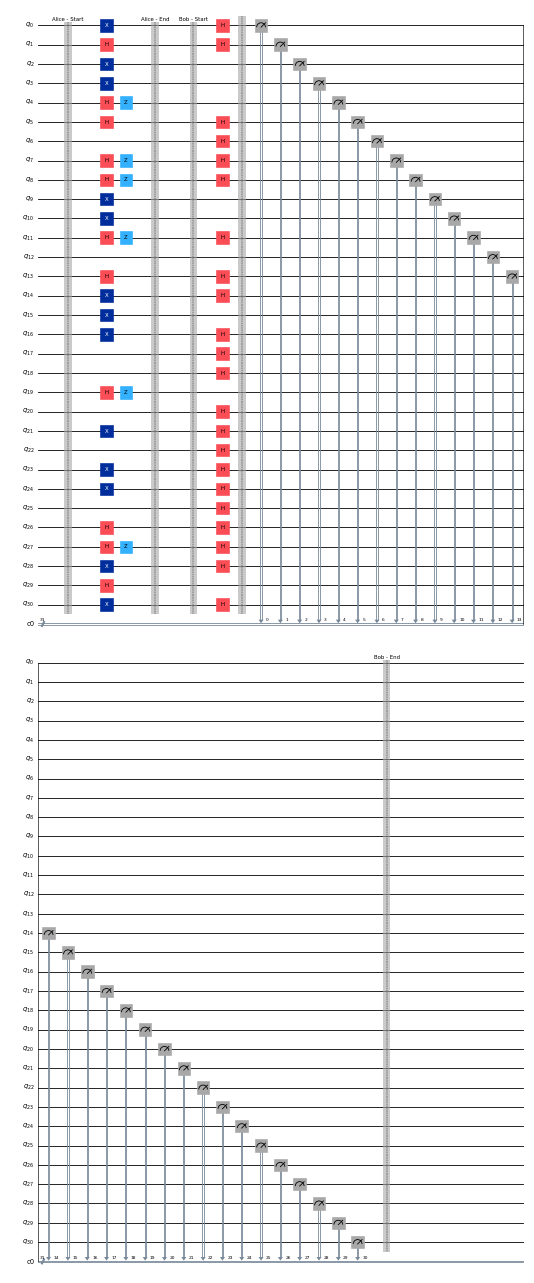

In [1]:
from qiskit import QuantumCircuit
from main import simulate_bb84_without_eve
num_qubits = 31
qc = QuantumCircuit(num_qubits)
simulate_bb84_without_eve(qc, num_qubits)

qc.draw(output='mpl', scale= 0.3)


Alice original bits
[0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Bob Measurments is:
[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Alice key is:
b'\xd6t\x83\xa2\xaa\x1a\xfa~\x19\x83\x94\xba\x84\x98\xa8T\xaaK\x98_\xb7\xd1\x1f\x9e\xe4/%y(\x9ep\xba\x803y\xb3P\xc4%\xabr\xe0d\xb1\x95\x873c'
Alice sifted bits: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Bob sifted bits: [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
Alice's sifted key count is:18
Bob's sifted key count is:18
Key exchange failed.


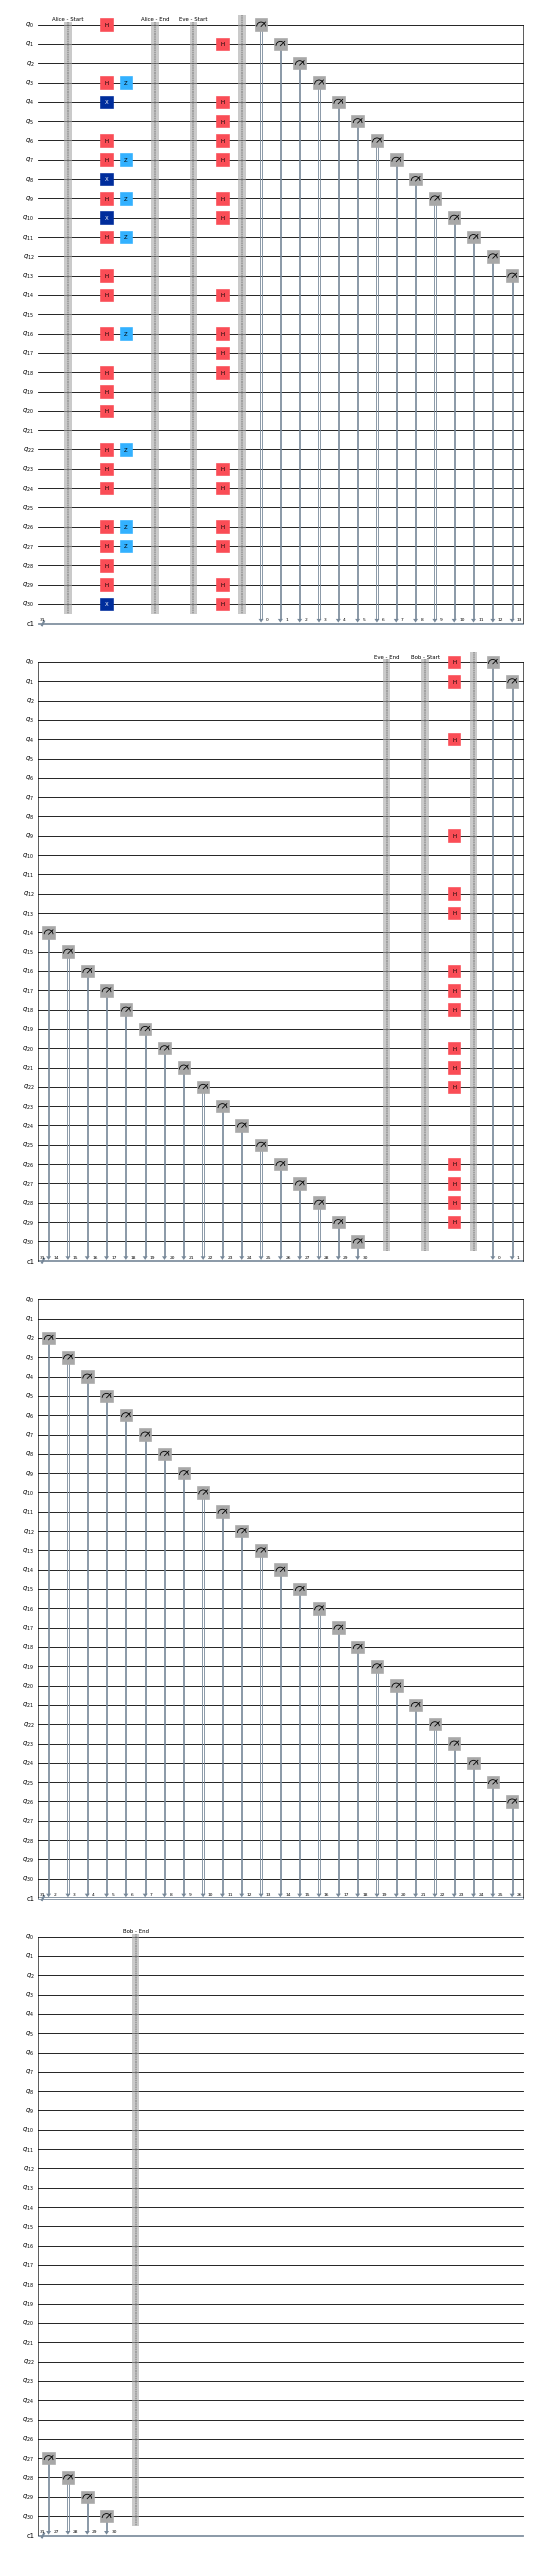

In [2]:
from main import simulate_bb84_with_eve
qc_with_eve = QuantumCircuit(num_qubits)
simulate_bb84_with_eve(qc_with_eve, num_qubits)
qc_with_eve.draw(output='mpl', scale= 0.3)